In [4]:
env = 'colab' # 'local' or 'colab'

In [ ]:
if env == 'colab':  
    !pip install ipynb
    !pip install huggingface-hub
    !pip install datasets
    !pip install nltk
    !pip install transformers
    !pip install umap-learn
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import torch
from tqdm.notebook import tqdm

In [15]:
from Daily_Dialog_loader import get_DailyDialog #custom function

In [16]:
df_train = get_DailyDialog()

Downloading:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/4.48M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset daily_dialog downloaded and prepared to /root/.cache/huggingface/datasets/daily_dialog/default/1.0.0/c03444008e9508b8b76f1f6793742d37d5e5f83364f8d573c2747bff435ea55c. Subsequent calls will reuse this data.


In [7]:
df_train.head()

utter_hashed  ... utter_in_dialog
0 -9223215459907611268  ...             [3]
1 -9223159658322746178  ...            [11]
2 -9222646307778946386  ...             [8]
3 -9222560108880336129  ...          [0, 0]
4 -9222532152297896019  ...             [3]

[5 rows x 4 columns]

## BERT vectorization

In [30]:
model_bert, tokenizer_bert, pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')
#model_bert, tokenizer_bert, pretrained_weights = (transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')

In [31]:
tokenizer = tokenizer_bert.from_pretrained(pretrained_weights,do_lower_case=True)
model = model_bert.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [33]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [34]:
tokenized = df_train.utter.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [35]:
df_train['bert_token'] = tokenized

In [36]:
df_train.head()

utter_hashed  ...                                         bert_token
0 -9223080995169461408  ...  [101, 2498, 2172, 1012, 2054, 1005, 1055, 2047...
1 -9222794897071190346  ...  [101, 2045, 2442, 2022, 2242, 3308, 2007, 2014...
2 -9222567331442343615  ...  [101, 2079, 2111, 5660, 1037, 2843, 1997, 2569...
3 -9221680524797725346  ...  [101, 2748, 1012, 5791, 2994, 1999, 1996, 2465...
4 -9221336517817173761  ...  [101, 2007, 5165, 1010, 2909, 1012, 2089, 1045...

[5 rows x 5 columns]

Distribution of utterances lenght 

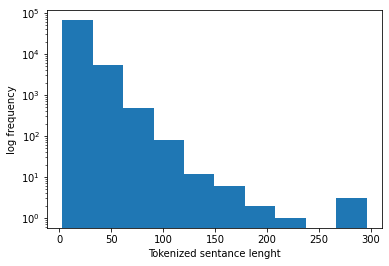

In [37]:
plt.hist(list(map(len, df_train['bert_token'])), log=True)
plt.xlabel('Tokenized sentance lenght')
plt.ylabel('log frequency')
plt.show()

In [38]:
max_len = df_train.bert_token.apply(len).max()

In [39]:
padded = np.array([i + [0]*(max_len-len(i)) for i in df_train.bert_token])

In [40]:
padded[53397]

array([ 101, 2878, 9440, 2003, 2126, 2488, 2084, 4124, 1010, 3404, 2033,
       1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [41]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(72462, 296)

In [42]:
def BERT_enc(padded_vect, attent_vect):
  input_ids = torch.tensor(padded_vect)  
  attention_mask = torch.tensor(attent_vect)

  batch_size = 200
  output = []

  for idx in tqdm(range(0, len(padded), batch_size)):
      
      batch = input_ids[idx:idx + batch_size].to(device)
      part_attention_mask = attention_mask[idx:idx + batch_size].to(device)

      with torch.no_grad():
          last_hidden_states = model(batch, attention_mask=part_attention_mask)
          output.append(last_hidden_states[0].cpu()[:,0,:])
  return output

I will vectorize the dataset in to passes, otherwise my environment falls

In [43]:
n_half = df_train.shape[0]//2

In [44]:
out_1half = BERT_enc(padded[:n_half], attention_mask[:n_half])
out_1half = torch.cat(out_1half,dim = 0)
out_1half.shape

  0%|          | 0/363 [00:00<?, ?it/s]

torch.Size([36231, 768])

In [45]:
out_2half = BERT_enc(padded[n_half:], attention_mask[n_half:])
out_2half = torch.cat(out_2half,dim = 0)
out_2half.shape

  0%|          | 0/363 [00:00<?, ?it/s]

torch.Size([36231, 768])

In [46]:
bert_vectorized = torch.cat([out_1half, out_2half],dim = 0)

In [47]:
bert_vectorized.shape

torch.Size([72462, 768])

In [48]:
bert_vectorized.numpy().dump('/content/drive/My Drive/NN-for-text/data/BERT/Bert_emb_nr.dat')

You can upload vectorized utterances from .data folder

In [7]:
bert_vectorized = np.load('/content/drive/My Drive/NN-for-text/data/BERT/Bert_emb_nr.dat', allow_pickle=True)

## Dimentionaliy reduction, visual exploration

In [28]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import umap 

In [29]:
import plotly.graph_objects as go
import plotly.express as px

#### PCA

In [30]:
pca = PCA(n_components = 3)
pca_result = pca.fit_transform(bert_vectorized)

In [31]:
pca_result.dump('/content/drive/My Drive/NN-for-text/data/BERT/DD_bert_nr_pca.dat')

In [32]:
fig = px.scatter_3d(
    pca_result, x=0, y=1, z=2,
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_traces(marker_size = 2)
fig.show()

I see sandwich like shape, with two clusters :)

In [33]:
fig.write_html('/content/drive/My Drive/NN-for-text/data/BERT/DD_bert_nr_pca.html')

[Text(0, 0.5, 'PC2'), Text(0.5, 0, 'PC1')]

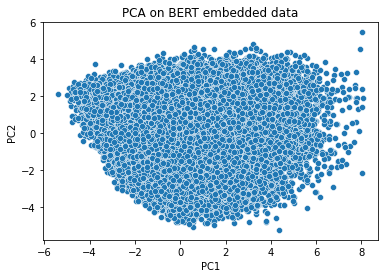

In [45]:
ax = sns.scatterplot(
    x=pca_result[:,0], y=pca_result[:,1]
)
ax.set_title('PCA on BERT embedded data')
ax.set(xlabel='PC1', ylabel='PC2')

In [46]:
fig_pca_2d = ax.get_figure()

In [47]:
fig_pca_2d.savefig('/content/drive/My Drive/NN-for-text/data/BERT/bert_nr_pca_2d.png')

#### t-SNE

In [35]:
tsne = TSNE(n_components=2, verbose=0, perplexity=15, n_iter=300)
tsne_results = tsne.fit_transform(bert_vectorized)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [36]:
tsne_results.dump('/content/drive/My Drive/NN-for-text/data/BERT/DD_bert_nr_tsne.dat')

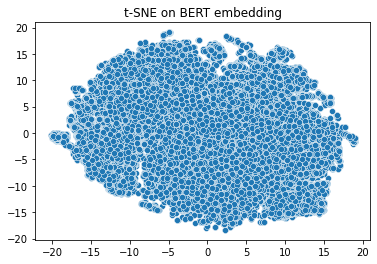

In [48]:
ax1 = sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1]
).set_title('t-SNE on BERT embedding')

In [49]:
fig_tsne = ax1.get_figure()
fig_tsne.savefig('/content/drive/My Drive/NN-for-text/data/BERT/bert_nr_tsne.png')

#### UMAP

In [38]:
fit = umap.UMAP()
u = fit.fit_transform(bert_vectorized)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.



In [113]:
u.dump('/content/drive/My Drive/NN-for-text/data/BERT/bert_nr_umap_dimred.dat')

In [39]:
fit.get_params()

{'a': None,
 'angular_rp_forest': False,
 'b': None,
 'dens_frac': 0.3,
 'dens_lambda': 2.0,
 'dens_var_shift': 0.1,
 'densmap': False,
 'disconnection_distance': None,
 'force_approximation_algorithm': False,
 'init': 'spectral',
 'learning_rate': 1.0,
 'local_connectivity': 1.0,
 'low_memory': True,
 'metric': 'euclidean',
 'metric_kwds': None,
 'min_dist': 0.1,
 'n_components': 2,
 'n_epochs': None,
 'n_jobs': -1,
 'n_neighbors': 15,
 'negative_sample_rate': 5,
 'output_dens': False,
 'output_metric': 'euclidean',
 'output_metric_kwds': None,
 'precomputed_knn': (None, None, None),
 'random_state': None,
 'repulsion_strength': 1.0,
 'set_op_mix_ratio': 1.0,
 'spread': 1.0,
 'target_metric': 'categorical',
 'target_metric_kwds': None,
 'target_n_neighbors': -1,
 'target_weight': 0.5,
 'tqdm_kwds': {'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]',
  'desc': 'Epochs completed',
  'disable': True},
 'transform_mode': 'embedding',
 'transform_queue_size'

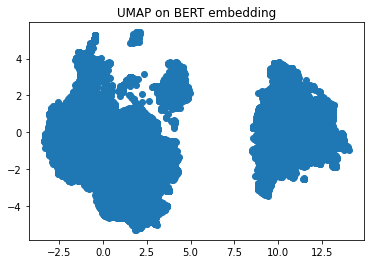

In [50]:
plt.scatter(u[:,0], u[:,1])
plt.title('UMAP on BERT embedding')
plt.savefig('/content/drive/My Drive/NN-for-text/data/BERT/bert_nr_umap.png')

## Clustering

In [52]:
from sklearn.neighbors import NearestNeighbors

In [53]:
knn = NearestNeighbors(n_neighbors=15)

In [54]:
knn.fit(bert_vectorized)

NearestNeighbors(n_neighbors=15)

In [27]:
_, neighbours = knn.kneighbors([bert_vectorized[55980].numpy()])

In [28]:
neighbours = df_train.iloc[neighbours[0].tolist()]['utter']

In [ ]:
for n in neighbours:
  print(f"|{n}|")

| Does it bother you when you have to chew a lot ? |
| Does it bother you when you eat something really sweet ? |
| Do you have a lot on your mind when you try to go to sleep ? |
| what do you use to eat it ? |
| Don't you feel dull ? |
| What do you do to deal with the stress ? |
|What stresses you out the most ? |
| Is there some reason why you can ’ t get enough sleep ? |
| How do you protect yourself from chapped lips ? |
| What do you normally eat ? |
| What things make you excited ? |
| Is this the only kind you have ? |
| Is that how you feel on the bus ? |
| Don't you feel dizzy when you have to get up ? |
| How late do you try to go to sleep ? |


Let's explore more exmples

In [12]:
sample = np.arange(1,72462,4000)

In [55]:
for u in sample:
  _, neighbours = knn.kneighbors([bert_vectorized[u].numpy()])
  neighbours = df_train.iloc[neighbours[0].tolist()]['utter']
  with open('/content/drive/My Drive/NN-for-text/data/BERT/bert_knn_neighbours_example.txt', 'a') as f:
    for n in neighbours:
      f.write(n+'\n')
    f.write('\n')


## K-means

In [50]:
from sklearn.cluster import KMeans

In [53]:
ssd = [] # Sum of squared distances
n_clust = np.arange(1,100,10)
for clust in n_clust:
    km = KMeans(clust)
    km.fit(bert_vectorized)
    with open('ssd.txt', 'a') as out_f:
        out_f.write(str(km.inertia_)+'\n')
    ssd.append(km.inertia_)

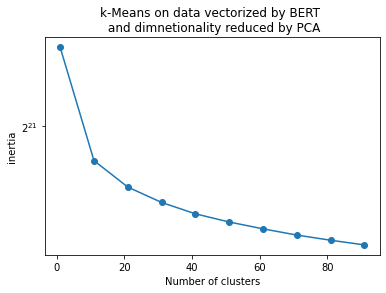

In [111]:
plt.plot(n_clust, ssd, marker = 'o' )
plt.semilogy(basey=2)
plt.xlabel('Number of clusters')
plt.ylabel('inertia')
plt.title('k-Means on data vectorized by BERT \n and dimnetionality reduced by PCA')
plt.savefig('/content/drive/My Drive/NN-for-text/data/BERT/bert_pca_kmeans_elbow.png')

In [ ]:
clust = 12
km = KMeans(clust)
km.fit(bert_vectorized)

In [81]:
labels = km.predict(bert_vectorized)
df_train['bert_kmeans_label'] = labels

In [82]:
df_train['bert_kmeans_label'].value_counts()

6     8979
9     8543
11    7661
2     7218
3     6867
4     6377
1     6217
8     5560
0     5085
10    3875
7     3042
5     3038
Name: bert_kmeans_label, dtype: int64

In [105]:
clust_9 = df_train[df_train['bert_kmeans_label'] == 9]['utter'].to_list()

In [107]:
for n in clust_9[:15]:
  print(f"|{n}|")

| I know you don ’ t want to pay for a job , but I think it ’ s time we consulted a headhunter . |
| He's after your own heart , it is important . |
| It wouldn't be worth the trouble in that case , would it ? Let's still use cartons . |
| I think something must be done . |
| I want to post this package to the United States . |
| Alright , let's look at some others . |
| I'll be getting money on Friday , and I'll get it back to you then . |
| Yes , but if you choose some good B2B websites , such problems can be avoided . |
| Well , I wonder if you could track an order I placed with you last month . It hasn ’ t arrived yet . |
| Ok , whatever . See , I'm putting it in the garbage can . |
| Sure . Go back and take the third turning on the left . |
| Don't be silly . It's no trouble at all . |
|There will be another sandstorm here tomorrow . |
| Well . You know I hate walking , but I can ’ t wait to see your guys ’ video . |
| I am not good at it by any means . Give me some advice . |


Too big clusters, sentances inside are diverse. 

In [84]:
df_train[['utter', 'bert_kmeans_label']].to_excel('/content/drive/My Drive/NN-for-text/data/BERT/DD_bert_k12_means_clust.xlsx')

Let's see how clusters look on UMAP reduced data

Text(0.5, 1.0, 'k-Means clusters on UMAP, k=12')

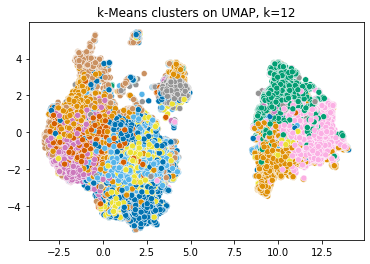

In [108]:
ax_lb = sns.scatterplot(
    x=u[:,0], y=u[:,1], hue = labels, palette = "colorblind", legend = False
)
ax_lb.set_title('k-Means clusters on UMAP, k=12')
#ax_lb.legend(loc='lower right')

In [109]:
fig_lb = ax_lb.get_figure()
fig_lb.savefig('/content/drive/My Drive/NN-for-text/data/BERT/km_clust_on_umap.png')